
# Created By Arthkumar Patel


In [1]:
# Import necessory modules for the code
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Assignemnt2").getOrCreate()

In [2]:
# Load Sampledata's csv file. Made some changes so that it can work for both sample data and whole dataset.
# Also removed duplicate data entries.
campaign_data = spark.read.csv("/Users/whitney/Courses/649/Spring21/website/assignments/Sampledata.csv",header=True,inferSchema=True).distinct()
campaign_data = campaign_data.withColumn('contbr_zip', campaign_data['contbr_zip'].cast('integer') ).withColumn('contb_receipt_amt',campaign_data['contb_receipt_amt'].cast('double'))

## Below function includes answers for Question 1-5 

In [5]:
def fun_Q1to5():
    candidate_total_donations = campaign_data.groupby('cand_nm').count().withColumnRenamed('cand_nm','Candidate Name').withColumnRenamed('count','No. of Donations')
    print('\033[1m'+'Answer For Question 1 :'+'\033[0m')
    print('\033[1m'+'No. of the Donations Each Candidate Received.'+'\033[0m')
    print('')
    candidate_total_donations.show(35)
    print('---------------------------------------------------------------------------------------------------------------------')
    
    candidate_donation_amount = campaign_data.groupby('cand_nm').sum('contb_receipt_amt').withColumnRenamed('cand_nm','Candidate Name').withColumnRenamed('sum(contb_receipt_amt)','Total Donation Received ($)')
    print('')
    print('\033[1m'+'Answer For Question 2 :'+'\033[0m')
    print('\033[1m'+'Total Amount of Donation Each Candidate Received.'+'\033[0m')
    print('')
    candidate_donation_amount.show(35)
    print('---------------------------------------------------------------------------------------------------------------------')
    
    # Removing Duplicate Candidate Entries from datasetm based on 6 columns mentioned below.
    unique_contributors = campaign_data.dropDuplicates(('contbr_nm','contbr_city','contbr_st','contbr_zip','contbr_employer','contbr_occupation'))
    unique_contributors_grouped = unique_contributors.groupby('cand_nm').count().withColumnRenamed('cand_nm','Candidate Name').withColumnRenamed('count','No. of Unique Contributors')
    print('')
    print('\033[1m'+'Answer For Question 3 :'+'\033[0m')
    print('\033[1m'+'No. of the Unique Contributors Each Candidate Have.'+'\033[0m')
    print('')
    unique_contributors_grouped.show(35)
    print('---------------------------------------------------------------------------------------------------------------------')
    
    # Filtered out negative values as they can have corresponding positive transactions in whole dataset. Also Negative values affect overall result of Standard Deviation.  
    filtered_campaign_data = campaign_data[campaign_data['contb_receipt_amt']>0]
    mean_std_donations = filtered_campaign_data.groupby('cand_nm').agg(F.avg('contb_receipt_amt'),F.stddev_pop('contb_receipt_amt')).withColumnRenamed('cand_nm','Candidate Name').withColumnRenamed('avg(contb_receipt_amt)','Mean of Donation Received ($)').withColumnRenamed('stddev_pop(contb_receipt_amt)','STDEV of Donation Received ($)')
    print('')
    print('\033[1m'+'Answer For Question 4 :'+'\033[0m')
    print('\033[1m'+'Mean & Standard Deviation of the Donations For Each Candidate.'+'\033[0m')
    print('')
    mean_std_donations.show(35)
    print('---------------------------------------------------------------------------------------------------------------------')
    
    campaign_data_abs = campaign_data.withColumn('contb_receipt_amt',F.abs(campaign_data['contb_receipt_amt']))
    small_contributors = campaign_data_abs.where(F.col('contb_receipt_amt')<50).groupby('cand_nm').count()
    # this is total no. of donations for each candidate.
    total_donations = campaign_data.groupby('cand_nm').count().withColumnRenamed('count','oldcount').withColumnRenamed('cand_nm','Name')
    
    # Performed inner join.
    joined_dataset = small_contributors.join(total_donations, small_contributors.cand_nm == total_donations.Name, 'inner')
    joined_dataset_percentage = joined_dataset.withColumn('Percentage of Donations by Small Contributors',F.col('count')*100/F.col('oldcount'))
    
    small_contributors_percentage = joined_dataset_percentage.select('Name','Percentage of Donations by Small Contributors')
    print('')
    print('\033[1m'+'Answer For Question 5 :'+'\033[0m')
    print('\033[1m'+'Percentage of Each Campaign’s Donations Done by Small Contributors, That is Donations Under $50.'+'\033[0m')
    print('')
    small_contributors_percentage.show(35)

In [6]:
# Function call for answers of Question 1-5.
fun_Q1to5()

Answer For Question 1 :
No. of the Donations Each Candidate Received.

+--------------------+----------------+
|      Candidate Name|No. of Donations|
+--------------------+----------------+
|    Ryan, Timothy J.|              16|
|Sestak, Joseph A....|               3|
|  Biden, Joseph R Jr|           34608|
|         Steyer, Tom|              28|
|      Bullock, Steve|              93|
|     Booker, Cory A.|             445|
|Weld, William Flo...|              27|
|Swalwell, Eric Mi...|               6|
|    Sanders, Bernard|           13887|
|Hickenlooper, Joh...|              16|
|    Charles, Mark R.|               1|
|       Moulton, Seth|              14|
|  Warren, Elizabeth |            4481|
|    Delaney, John K.|              17|
|Gillibrand, Kirsten |              46|
|   Klobuchar, Amy J.|            1029|
|Gravel, Maurice R...|               1|
|O’Rourke, Robert ...|             541|
|Bloomberg, Michae...|               2|
|       Jorgensen, Jo|              32|
|       I

+--------------------+---------------------------------------------+
|                Name|Percentage of Donations by Small Contributors|
+--------------------+---------------------------------------------+
|    Ryan, Timothy J.|                                         37.5|
|Sestak, Joseph A....|                           33.333333333333336|
|  Biden, Joseph R Jr|                            58.32755432269995|
|         Steyer, Tom|                                         25.0|
|      Bullock, Steve|                           41.935483870967744|
|     Booker, Cory A.|                           54.831460674157306|
|Weld, William Flo...|                           33.333333333333336|
|Swalwell, Eric Mi...|                           33.333333333333336|
|    Sanders, Bernard|                            82.14877223302369|
|Hickenlooper, Joh...|                                         37.5|
|       Moulton, Seth|                            7.142857142857143|
|  Warren, Elizabeth |            

# AWS CLI Export For Question 1-5

aws emr create-cluster --applications Name=Spark Name=Zeppelin --ec2-attributes '{"InstanceProfile":"EMR_EC2_DefaultRole","SubnetId":"subnet-ad729ad0","EmrManagedSlaveSecurityGroup":"sg-0f503418a56b719de","EmrManagedMasterSecurityGroup":"sg-004636ad1ed2bb980"}' --service-role EMR_DefaultRole --enable-debugging --release-label emr-6.2.0 --log-uri 's3n://aws-logs-491435952613-us-east-2/elasticmapreduce/' --steps '[{"Args":["spark-submit","--deploy-mode","client","s3://py-files-new/Assignment2_new.py","-i","s3://arth-patel-dataset/P00000001-ALL.csv"],"Type":"CUSTOM_JAR","ActionOnFailure":"CONTINUE","Jar":"command-runner.jar","Properties":"","Name":"Spark application New"}]' --name 'My cluster' --instance-groups '[{"InstanceCount":1,"EbsConfiguration":{"EbsBlockDeviceConfigs":[{"VolumeSpecification":{"SizeInGB":32,"VolumeType":"gp2"},"VolumesPerInstance":2}]},"InstanceGroupType":"MASTER","InstanceType":"m5.xlarge","Name":"Master Instance Group"},{"InstanceCount":2,"EbsConfiguration":{"EbsBlockDeviceConfigs":[{"VolumeSpecification":{"SizeInGB":32,"VolumeType":"gp2"},"VolumesPerInstance":2}]},"InstanceGroupType":"CORE","InstanceType":"m5.xlarge","Name":"Core Instance Group"}]' --configurations '[{"Classification":"spark","Properties":{}}]' --scale-down-behavior TERMINATE_AT_TASK_COMPLETION --region us-east-2

## I have used this syntax to run the code for Question 1-5 in Spark-Shell locally. 

In [5]:
# def files_from_args():
#     import argparse
#     parser = argparse.ArgumentParser()
#     parser.add_argument('-i', '--input', default='input')
#     parser.add_argument('-o', '--output',default='output')
#     args = parser.parse_args()
#     return (args.input, args.output)

# if __name__ == "__main__":
#     inputfile, outputfile = files_from_args()
#     fun_Q1to5(inputfile, outputfile)
    
# -i "input_file_path" -o "output_file_path"

## I have used this function to run the code for Question 6 in Spark-Shell locally.

In [6]:
# def fun_Q6(input,output):
#     campaign_data = spark.read.csv(input,header=True,inferSchema=True).distinct()
#     campaign_data = campaign_data.withColumn('contbr_zip', campaign_data['contbr_zip'].cast('integer') ).withColumn('contb_receipt_amt',campaign_data['contb_receipt_amt'].cast('double'))
#     hist_filtered_data = campaign_data.filter((campaign_data.cand_nm=='Biden, Joseph R Jr') | (campaign_data.cand_nm=='Trump, Donald J.'))
#     hist_total_data = hist_filtered_data[hist_filtered_data['contb_receipt_amt']>0]
#     final_hist_data = hist_total_data.select('cand_nm','contb_receipt_amt')
#     final_hist_data.write.format('csv').save(output)

# def files_from_args():
#     import argparse
#     parser = argparse.ArgumentParser()
#     parser.add_argument('-i', '--input', default='input')
#     parser.add_argument('-o', '--output',default='output')
#     args = parser.parse_args()
#     return (args.input, args.output)

# if __name__ == "__main__":
#     inputfile, outputfile = files_from_args()
#     fun_Q6(inputfile, outputfile)

In [7]:
# Importing necessary modules required for Question 6.
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tt

In [11]:
# Read all csv files generated by AWS.
path = r'AWS_Files/'  # change the path to read output files.
all_files = glob.glob(path + "/*.csv")
li = []

for filename in all_files:
    df = pd.read_csv(filename,header=None)
    li.append(df)
    
hist_data = pd.concat(li, axis=0).rename(columns={0: "Candidate Name", 1: "Donation Amount"})

In [12]:
# Filter data for Trump and Biden.
trump_hist_data = hist_data[hist_data['Candidate Name']=="Trump, Donald J."]
biden_hist_data = hist_data[hist_data['Candidate Name']=="Biden, Joseph R Jr"]

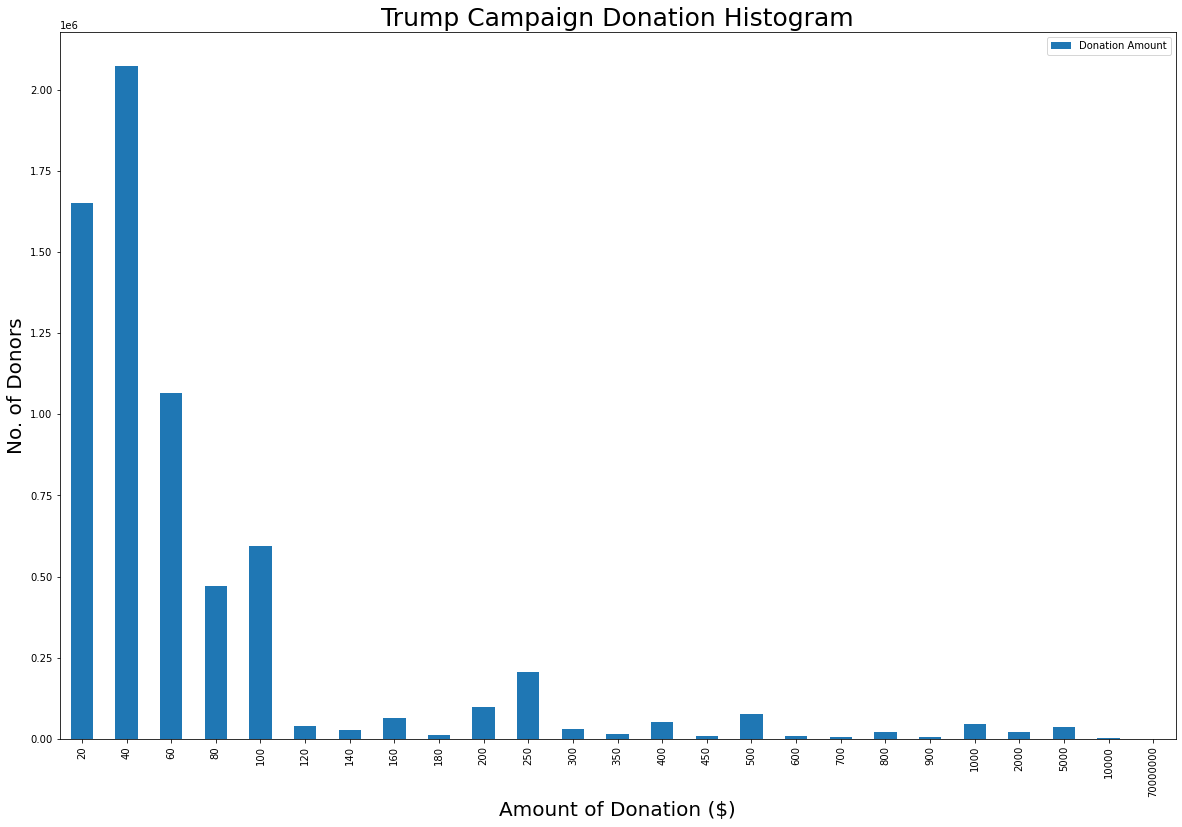

In [13]:
plt.rcParams["figure.figsize"] = (20,13)
# To create histogram I divided the data into bins and then I plotted barplot which eventually turns into Histogram.
bins_range_trump = [0,20,40,60,80,100,120,140,160,180,200,250,300,350,400,450,500,600,700,800,900,1000,2000,5000,10000,70000000]
trump_hist_data_new = trump_hist_data.groupby(pd.cut(trump_hist_data['Donation Amount'],bins_range_trump)).count()
trump_hist_data_new['Range'] = [20,40,60,80,100,120,140,160,180,200,250,300,350,400,450,500,600,700,800,900,1000,2000,5000,10000,70000000]
trump_hist_data_new.plot.bar(x='Range',y='Donation Amount')
plt.xlabel('Amount of Donation ($)',fontsize=20)
plt.ylabel('No. of Donors',fontsize=20)
plt.title('Trump Campaign Donation Histogram',fontsize=25)
plt.show()
# Histogram on xtick shows the donation between that range. Like bar on 20 shows donation for (0,20].

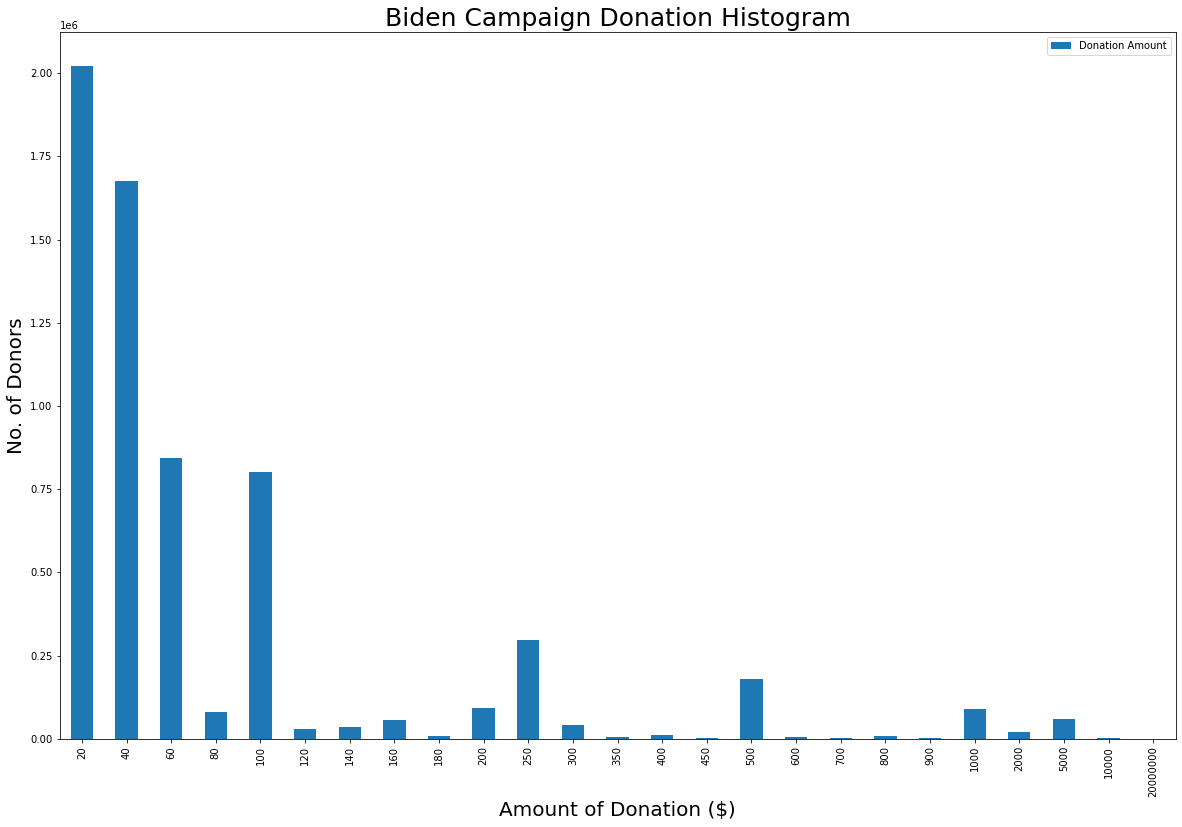

In [14]:
# To create histogram I divided the data into bins and then I plotted barplot which eventually turns into Histogram.
bins_range_biden = [0,20,40,60,80,100,120,140,160,180,200,250,300,350,400,450,500,600,700,800,900,1000,2000,5000,10000,20000000]
biden_hist_data_new = biden_hist_data.groupby(pd.cut(biden_hist_data['Donation Amount'],bins_range_biden)).count()
biden_hist_data_new['Range'] = [20,40,60,80,100,120,140,160,180,200,250,300,350,400,450,500,600,700,800,900,1000,2000,5000,10000,20000000]
biden_hist_data_new.plot.bar(x='Range',y='Donation Amount')
plt.xlabel('Amount of Donation ($)',fontsize=20)
plt.ylabel('No. of Donors',fontsize=20)
plt.title('Biden Campaign Donation Histogram',fontsize=25)
plt.show()
# Histogram on xtick shows the donation between that range. Like bar on 20 shows donation for (0,20].

# AWS CLI Export For Question 6

aws emr create-cluster --applications Name=Spark Name=Zeppelin --ec2-attributes '{"InstanceProfile":"EMR_EC2_DefaultRole","SubnetId":"subnet-9555e7fe","EmrManagedSlaveSecurityGroup":"sg-0f503418a56b719de","EmrManagedMasterSecurityGroup":"sg-004636ad1ed2bb980"}' --service-role EMR_DefaultRole --enable-debugging --release-label emr-6.2.0 --log-uri 's3n://aws-logs-491435952613-us-east-2/elasticmapreduce/' --steps '[{"Args":["spark-submit","--deploy-mode","client","s3://py-files-new/hist_total.py","-i","s3://arth-patel-dataset/P00000001-ALL.csv"],"Type":"CUSTOM_JAR","ActionOnFailure":"CONTINUE","Jar":"command-runner.jar","Properties":"","Name":"Spark application Q6"},{"Args":["spark-submit","--deploy-mode","client","s3://py-files-new/hist_total.py","-i","s3://arth-patel-dataset/P00000001-ALL.csv","-o","s3://arth-patel-output"],"Type":"CUSTOM_JAR","ActionOnFailure":"CONTINUE","Jar":"command-runner.jar","Properties":"","Name":"Spark application Q6Up"}]' --name 'My cluster' --instance-groups '[{"InstanceCount":1,"EbsConfiguration":{"EbsBlockDeviceConfigs":[{"VolumeSpecification":{"SizeInGB":32,"VolumeType":"gp2"},"VolumesPerInstance":2}]},"InstanceGroupType":"MASTER","InstanceType":"m5.xlarge","Name":"Master Instance Group"},{"InstanceCount":2,"EbsConfiguration":{"EbsBlockDeviceConfigs":[{"VolumeSpecification":{"SizeInGB":32,"VolumeType":"gp2"},"VolumesPerInstance":2}]},"InstanceGroupType":"CORE","InstanceType":"m5.xlarge","Name":"Core Instance Group"}]' --configurations '[{"Classification":"spark","Properties":{}}]' --scale-down-behavior TERMINATE_AT_TASK_COMPLETION --region us-east-2